# Reading and Correcting the Dataset

In [11]:
import pandas as pd
technica_Data = pd.read_csv("tst_technica_data.csv", usecols=[0,1,2,3,4,5,6,7,8])
print(technica_Data)
print(technica_Data.columns)

                      timestamp  ...                                           hashtags
0      2021-11-11T01:00:00.000Z  ...                                           security
1      2021-11-11T00:59:13.000Z  ...  ["60DaysOfDevOps","CopadoChampion","WomenInDev...
2      2021-11-11T00:58:37.000Z  ...                                       AWSCertified
3      2021-11-11T00:57:58.000Z  ...                                              AHA21
4      2021-11-11T00:57:52.000Z  ...  ["WiMIR","WomenInStem","WomenInTech","ismir2021"]
...                         ...  ...                                                ...
81320  2021-11-09T04:30:12.000Z  ...                       ["security","cybersecurity"]
81321  2021-11-09T04:30:12.000Z  ...                       ["security","cybersecurity"]
81322  2021-11-09T04:30:12.000Z  ...                       ["security","cybersecurity"]
81323  2021-11-09T04:30:07.000Z  ...  ["security","security","cybersecurity","100Day...
81324  2021-11-09T04:30:06.000Z 

In [12]:
import math
corrected_rows = []
headings = ['timestamp', 'id', 'author', 'body', 'language', 'sentiment_score', 'sentiment_label', 'location', 'hashtags']
for index, row in technica_Data.iterrows():
  content = row['body']
  label = row['sentiment_label']
  row_proper = [row['timestamp'], row['id'], row['author'], row['body'], row['language'], row['sentiment_score'], row['sentiment_label'], row['location'], row['hashtags']]
  if type(label) == float and math.isnan(label):
    continue
  if type(content) == float and math.isnan(content):
    continue
  corrected_rows.append(row_proper)
corrected_data = pd.DataFrame(corrected_rows, columns=headings)
print(corrected_data)
print(corrected_data.columns)
corrected_data.to_csv("corrected_data.csv")

                      timestamp  ...                                           hashtags
0      2021-11-11T01:00:00.000Z  ...                                           security
1      2021-11-11T00:59:13.000Z  ...  ["60DaysOfDevOps","CopadoChampion","WomenInDev...
2      2021-11-11T00:58:37.000Z  ...                                       AWSCertified
3      2021-11-11T00:57:58.000Z  ...                                              AHA21
4      2021-11-11T00:57:52.000Z  ...  ["WiMIR","WomenInStem","WomenInTech","ismir2021"]
...                         ...  ...                                                ...
78433  2021-11-09T04:30:12.000Z  ...                       ["security","cybersecurity"]
78434  2021-11-09T04:30:12.000Z  ...                       ["security","cybersecurity"]
78435  2021-11-09T04:30:12.000Z  ...                       ["security","cybersecurity"]
78436  2021-11-09T04:30:07.000Z  ...  ["security","security","cybersecurity","100Day...
78437  2021-11-09T04:30:06.000Z 

# Using the Corrected Dataset

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

dataset = corrected_data
dataset = dataset[dataset['sentiment_label'] != 'neutral']
print(dataset["sentiment_label"].value_counts())
sentiment_label = dataset.sentiment_label.factorize()
print(sentiment_label)
content = dataset.body.values
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(content)
encoded_docs = tokenizer.texts_to_sequences(content)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

positive                                                                                                                                                                                                                                                                                                                                                                                                                      35844
negative                                                                                                                                                                                                                                                                                                                                                                                                                      19885
 Mariel J.Liebeskind                                                                                                                                            

# Training the Model

In [14]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding

embedding_vector_length = 32
vocab_size = 5000
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=32)

model.save('WomenConversationAnalysis.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           160000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 176,651
Trainable params: 176,651
Non-trainable params: 0
__________________________________________________

# Checking the Accuracy

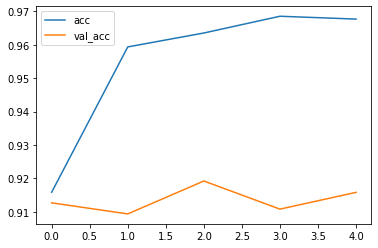

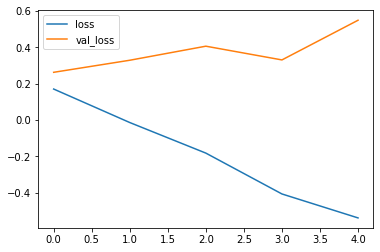

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plt.jpg")

# Testing the Model

In [16]:
import keras
model = keras.models.load_model('WomenConversationAnalysis.h5')

In [17]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", sentiment_label[1][prediction])

test_sentence1 = "Completed a course today! It was a lot of fun."
predict_sentiment(test_sentence1)
test_sentence2 = """ A threat actor is stealing people's payment card info. Stay Safe!!""" 
predict_sentiment(test_sentence2)

Predicted label:  positive
Predicted label:  negative


# Testing on Social Media using Web Scraping

In [19]:
import requests
import numpy as np
from bs4 import BeautifulSoup

%matplotlib inline

url = 'https://www.reddit.com/r/STEM/comments/ql9m1g/stem_classroom/'

response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')

text = soup.find("p", {"class": "_1qeIAgB0cPwnLhDF9XSiJM"})

print(text)

<p class="_1qeIAgB0cPwnLhDF9XSiJM">So, I’m a STEM specials teacher. I teach Pre-K through 4th and see students 3 times a week for a 45-minute specials class (the other two days they go to PE).</p>


In [20]:
text_to_test = text.text

print(text_to_test)

predict_sentiment(text_to_test)

So, I’m a STEM specials teacher. I teach Pre-K through 4th and see students 3 times a week for a 45-minute specials class (the other two days they go to PE).
Predicted label:  positive


# Visualizations

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(corrected_data['body'], 20)
for word, freq in common_words:
    print(word, freq)

the 171518
to 130467
and 119652
of 94200
in 82384
https 73262
co 71276
for 50267
womenintech 47556
that 44345
is 39843
you 39480
100daysofcode 32255
with 31211
on 29611
this 28684
we 28193
python 27152
it 26804
ai 26771


In [22]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(corrected_data['body'], 20)
for word, freq in common_words:
    print(word, freq)

https 73262
womenintech 47556
100daysofcode 32255
python 27152
ai 26771
datascience 23198
cybersecurity 23164
codenewbie 22040
javascript 21153
machinelearning 20166
devops 19652
äôs 19424
serverless 19420
women 17277
iot 17071
nodejs 16019
womenwhocode 15346
womeninstem 15112
github 14216
devcommunity 13992


These can be visualized in the form of bar graphs to get words and hashtags with the most positive and most negative messages. (I tried using iplot here but it didn't work on Google Colab)

Here is an example of a possible visualization of the number of positive, negative and neutral posts for each hashtag.

In [47]:
print(corrected_data)
print(corrected_data.columns)
hashtag_analysis = {}
for index, row in technica_Data.iterrows():
  try:
    hashtags = row["hashtags"]
    if type(hashtags) == float or type(row["sentiment_label"]) == float:
      continue
    if hashtags[0] == '[':
      all_hashtags = eval(row["hashtags"])
    else:
      all_hashtags = [hashtags]
    for key in all_hashtags:
      if key not in hashtag_analysis:
        hashtag_analysis[key] = {"positive" : 0, "negative" : 0, "neutral" : 0}
      if row["sentiment_label"] == "positive":
        hashtag_analysis[key]["positive"] += 1
      if row["sentiment_label"] == "negative":
        hashtag_analysis[key]["negative"] += 1
      if row["sentiment_label"] == "neutral":
        hashtag_analysis[key]["neutral"] += 1
  except:
    continue
print(hashtag_analysis)

                      timestamp  ...                                           hashtags
0      2021-11-11T01:00:00.000Z  ...                                           security
1      2021-11-11T00:59:13.000Z  ...  ["60DaysOfDevOps","CopadoChampion","WomenInDev...
2      2021-11-11T00:58:37.000Z  ...                                       AWSCertified
3      2021-11-11T00:57:58.000Z  ...                                              AHA21
4      2021-11-11T00:57:52.000Z  ...  ["WiMIR","WomenInStem","WomenInTech","ismir2021"]
...                         ...  ...                                                ...
78433  2021-11-09T04:30:12.000Z  ...                       ["security","cybersecurity"]
78434  2021-11-09T04:30:12.000Z  ...                       ["security","cybersecurity"]
78435  2021-11-09T04:30:12.000Z  ...                       ["security","cybersecurity"]
78436  2021-11-09T04:30:07.000Z  ...  ["security","security","cybersecurity","100Day...
78437  2021-11-09T04:30:06.000Z 

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 63743 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 63743 missing from current font.



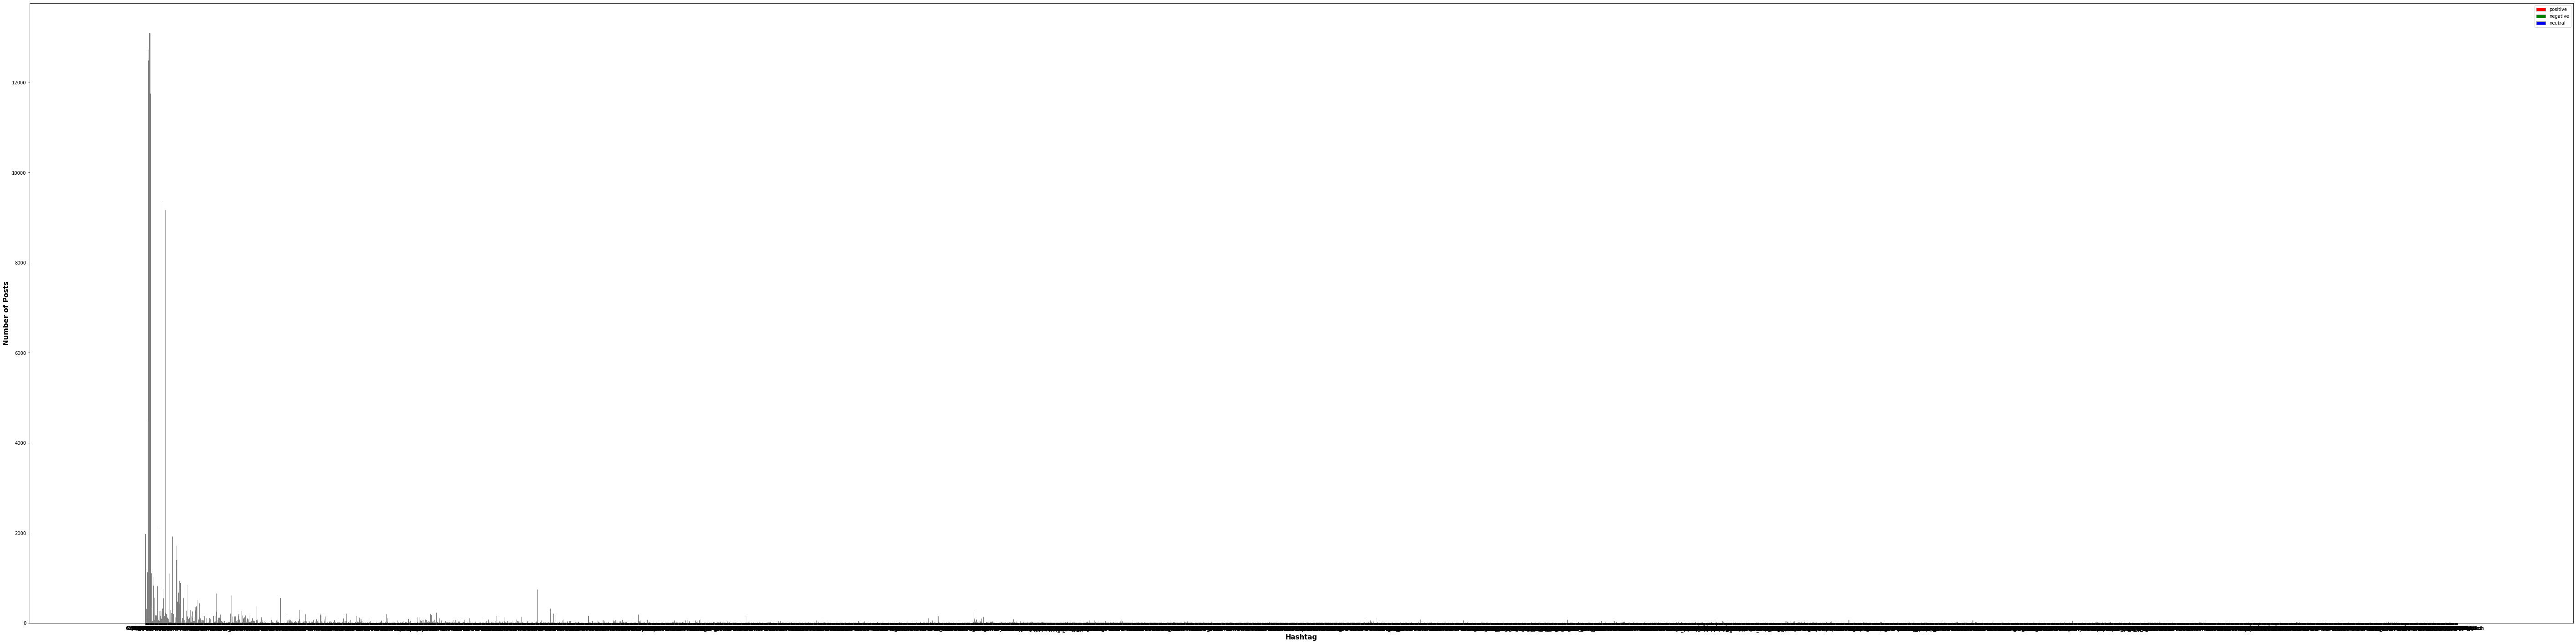

In [57]:
import numpy as np
import matplotlib.pyplot as plt

barWidth = 0.25
fig = plt.subplots(figsize =(100, 25))

positive = []
negative = []
neutral = []

for hashtag in hashtag_analysis.keys():
  positive.append(hashtag_analysis[hashtag]["positive"])
  negative.append(hashtag_analysis[hashtag]["negative"])
  neutral.append(hashtag_analysis[hashtag]["neutral"])

br1 = np.arange(len(positive))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, positive, color ='r', width = barWidth,
        edgecolor ='grey', label ='positive')
plt.bar(br2, negative, color ='g', width = barWidth,
        edgecolor ='grey', label ='negative')
plt.bar(br3, neutral, color ='b', width = barWidth,
        edgecolor ='grey', label ='neutral')
 
# Adding Xticks
plt.xlabel('Hashtag', fontweight ='bold', fontsize = 15)
plt.ylabel('Number of Posts', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(positive))], list(hashtag_analysis.keys()))
 
plt.legend()
plt.show()